# 1. Configuration & Setup

This section sets up all key configurations for reproducibility and environment control.  
We define:
- Random seed for consistent results  
- Device selection (CPU or GPU)
- Dataset path and loading configuration

In [ ]:
# =========================
# 1. Configuration & Setup
# =========================
# The CONFIG dictionary defines key hyperparameters and paths
# used throughout the autoencoder training and embedding pipeline.

import re
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from itertools import product
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

CONFIG = {
    # --- Model hyperparameters ---
    "latent_dim": 3,              # Dimension of the latent space (e.g., 2, 3, 5). 
                                  # Lower values are suitable for visualization; 
                                  # higher values capture more feature variance.

    "emb_dim": 16,                # Embedding dimension for the input 5-mer tokens 
                                  # before encoding into the latent space.

    # --- Training parameters ---
    "epochs": 600,                # Number of training epochs for the autoencoder.
    "batch_size": 24,             # Number of samples per training batch.
    "lr": 0.01,                   # Learning rate for the optimizer (Adam).

    # --- Feature configuration ---
    "use_unique_kmers": True,     # Whether to use only kmers observed in the dataset.
                                  # True  → restricts to 66 observed kmers (smaller embedding space).
                                  # False → uses all 432 theoretical kmers (larger embedding space).

    "latent_visualisation": True, # If True, produce a 2D scatter plot of latent features
                                  # (only meaningful when latent_dim ≥ 2).

    # --- File and directory paths ---
    "dataset_path": "Dataset/before_embedding.parquet",  # Input dataset before embedding.
    "output_dir": "Dataset/",                            # Output directory for processed datasets.
    "model_dir": "Models/",                              # Directory to save or load trained models.

    # --- Pretrained model usage ---
    "existing_encoder": "autoencoder_lat2_66_epoch600_trained.pth"
                                  # If None → train a new autoencoder.
                                  # If not None → load this pretrained model and update configuration
                                  # automatically based on its filename pattern.
}

# ---- Reproducibility ----
RNG = 42
np.random.seed(RNG)
random.seed(RNG)
torch.manual_seed(RNG)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

os.makedirs(CONFIG["model_dir"], exist_ok=True)
os.makedirs(CONFIG["output_dir"], exist_ok=True)


✅ Using device: cuda


In [2]:
# --- Automatically update CONFIG if existing encoder is provided ---
if CONFIG["existing_encoder"] is not None:
    fname = os.path.basename(CONFIG["existing_encoder"])

    # Pattern to capture latent dim, number of kmers, and epoch
    # Example filename: "autoencoder_lat2_66_epoch600_trained.pth"
    pattern = r"lat(\d+)_([0-9]+)_epoch(\d+)"
    match = re.search(pattern, fname)

    if match:
        lat_dim, kmer_count, epoch = match.groups()
        CONFIG["latent_dim"] = int(lat_dim)
        CONFIG["epochs"] = int(epoch)
        CONFIG["use_unique_kmers"] = (int(kmer_count) == 66)

        print(f"✅ CONFIG updated based on existing encoder: {fname}")
        print(f" → latent_dim = {CONFIG['latent_dim']}")
        print(f" → epochs = {CONFIG['epochs']}")
        print(f" → use_unique_kmers = {CONFIG['use_unique_kmers']}")
    else:
        print(f"⚠️ Warning: Could not parse configuration info from filename '{fname}'. Using default CONFIG values.")
else:
    print("ℹ️ No existing encoder provided — proceeding to train a new autoencoder.")

✅ CONFIG updated based on existing encoder: autoencoder_lat2_66_epoch601_trained.pth
 → latent_dim = 2
 → epochs = 601
 → use_unique_kmers = True


# 2. Load Dataset and Generate Valid 5-mers

In this section:
Here, we load the preprocessed dataset (`before_embedding.parquet`) and extract the 5-mer sequences.  
We also define the valid base combinations for each position and build the list of all possible or observed 5-mers.
- Define positional base constraints for 5-mer generation.
- Concatenate and extract all observed 5-mers from the dataset.
- Optionally choose between using only observed 5-mers or all 432 theoretical valid 5-mers.
- Construct mapping dictionaries:
  - `kmer_to_idx`: from 5-mer → index  
  - `idx_to_kmer`: from index → 5-mer  

These will serve as the discrete vocabulary for the autoencoder.


In [3]:
# =========================
# 2. Prepare k-mer Vocabulary
# =========================
reads_df = pd.read_parquet(CONFIG["dataset_path"])

# Define possible bases per position
pos_bases = [
    ['A', 'C', 'G', 'U'],   # position 1
    ['A', 'G', 'U'],        # position 2
    ['A', 'G', 'C'],        # position 3
    ['A', 'C', 'U'],        # position 4
    ['A', 'C', 'G', 'U'],   # position 5
]

# Combine all 5-mer columns
all_5mers = pd.concat([reads_df['Pre_5mer'], reads_df['In_5mer'], reads_df['Post_5mer']])
unique_5mers = all_5mers.dropna().unique().tolist()

# Choose between only kmers in data or all 432 possible kmers
if CONFIG["use_unique_kmers"]:
    valid_kmers = unique_5mers
else:
    valid_kmers = [''.join(p) for p in product(*pos_bases)]

VOCAB_SIZE = len(valid_kmers)
print(f"✅ Total valid 5-mers: {VOCAB_SIZE}")

# Create mapping dictionaries
kmer_to_idx = {kmer: idx for idx, kmer in enumerate(valid_kmers)}
idx_to_kmer = {idx: kmer for kmer, idx in kmer_to_idx.items()}


✅ Total valid 5-mers: 66


# 3. Define Autoencoder Model

We implement the 5-mer autoencoder architecture:
- **Embedding Layer:** Learns an embedding for each 5-mer token.
- **Encoder:** Projects the embedding to a latent vector of configurable size (`latent_dim`).
- **Decoder:** Reconstructs the original 5-mer from the latent vector.

The model allows flexibility to vary the latent dimension for different experiments.


In [4]:
# =========================
# 3. Autoencoder Definition
# =========================
class KmerAutoencoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=16, latent_dim=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.encoder = nn.Sequential(
            nn.Linear(emb_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, vocab_size)
        )

    def forward(self, x):
        emb = self.embedding(x)
        latent = self.encoder(emb)
        logits = self.decoder(latent)
        return logits, latent

# 4. Prepare Training Data

We prepare the training set by converting all valid 5-mers into indexed tensors.  
These serve as both inputs and targets for the reconstruction task, since the autoencoder learns to reproduce its inputs.


In [5]:
# =========================
# 4. Training Function
# =========================
def train_autoencoder(vocab_size, emb_dim, latent_dim, lr, epochs, batch_size):
    model = KmerAutoencoder(vocab_size, emb_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_tensor = torch.arange(vocab_size, dtype=torch.long)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, vocab_size, batch_size):
            batch = train_tensor[i:i + batch_size].to(device)
            optimizer.zero_grad()
            logits, _ = model(batch)
            loss = criterion(logits, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}")

    return model

# 5. Training Function Definition

This section defines the `train_autoencoder()` function, which handles:
- Model initialization  
- Training loop (with batch processing)
- Loss computation using `CrossEntropyLoss`
- Periodic loss printing for monitoring training progress

Hyperparameters like `latent_dim`, `epochs`, and `batch_size` can be customized for different experiments.


In [6]:
# =========================
# 5. Train & Save Model
# =========================
latent_dim = CONFIG["latent_dim"]
epochs = CONFIG["epochs"]


if not CONFIG["existing_encoder"]:
    model = train_autoencoder(
        vocab_size=VOCAB_SIZE,
        emb_dim=CONFIG["emb_dim"],
        latent_dim=latent_dim,
        lr=CONFIG["lr"],
        epochs=CONFIG["epochs"],
        batch_size=CONFIG["batch_size"]
    )

    # Save model file as <latent_dim>_<vocab_size>_trained
    model_name = f"autoencoder_lat{latent_dim}_{VOCAB_SIZE}_epoch{epochs}_trained.pth"
    torch.save(model.state_dict(), os.path.join(CONFIG["model_dir"], model_name))
    print(f"💾 Saved model to: {model_name}")
else:
    model_name = CONFIG["existing_encoder"]
    print("Skipped training due to use of existing autoencoder model")


Skipped training due to use of existing autoencoder model


# 6. Load Trained Model and Encode Dataset

In this section:
- Choose which trained model (2D or 3D) to use for encoding.
- Load the trained weights into the model.
- Map each 5-mer in the dataset to its corresponding index.
- Run batched inference to compute latent embeddings for all 5-mers efficiently.


In [7]:
# =========================
# 6. Embed k-mers for Dataset
# =========================
# Reload trained model
latent_model = KmerAutoencoder(VOCAB_SIZE, CONFIG["emb_dim"], CONFIG["latent_dim"])
latent_model.load_state_dict(torch.load(os.path.join(CONFIG["model_dir"], model_name), map_location=device))
latent_model.to(device)
latent_model.eval()

KmerAutoencoder(
  (embedding): Embedding(66, 16)
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=66, bias=True)
  )
)

# (Optional) Visualize Autoencoder

After training:
- The 2D latent embeddings are visualized to inspect clustering in latent space taking the first 2 latent dimension.

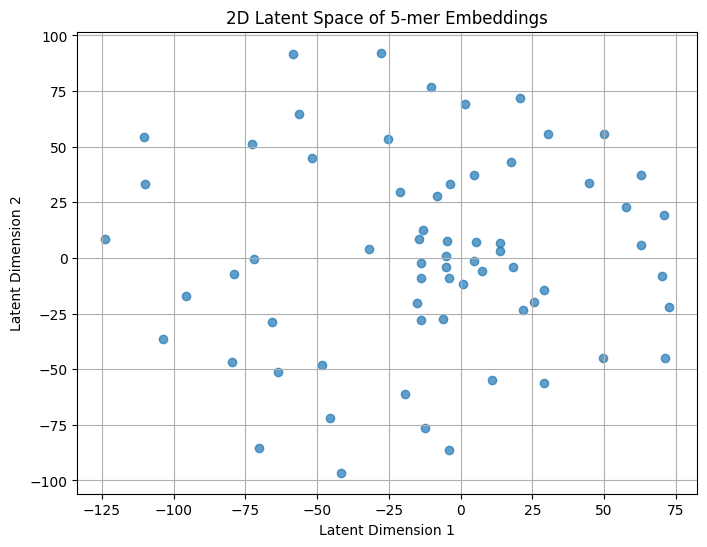

In [8]:
# =========================
# 6a. Latent Space Visualization (optional)
# =========================
if CONFIG["latent_visualisation"] == True:
    with torch.no_grad():
        all_kmers = torch.arange(VOCAB_SIZE).to(device)
        _, latents = latent_model(all_kmers)
        latents = latents.cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(latents[:, 0], latents[:, 1], alpha=0.7)
    plt.title("2D Latent Space of 5-mer Embeddings")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

In [9]:
# Map each k-mer column to index
for col in ['Pre_5mer', 'In_5mer', 'Post_5mer']:
    reads_df[f"{col}_idx"] = reads_df[col].map(kmer_to_idx).fillna(0).astype(int)

# Stack all indices for fast embedding
all_indices = pd.concat([
    reads_df['Pre_5mer_idx'],
    reads_df['In_5mer_idx'],
    reads_df['Post_5mer_idx']
], axis=0).to_numpy()

dataset = TensorDataset(torch.tensor(all_indices, dtype=torch.long))
loader = DataLoader(dataset, batch_size=4096)

latent_list = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        _, latent_batch = latent_model(batch)
        latent_list.append(latent_batch.cpu())

latent_all_np = torch.cat(latent_list, dim=0).numpy()

# Split into Pre, In, and Post parts
n = len(reads_df)
latent_pre, latent_in, latent_post = latent_all_np[:n], latent_all_np[n:2*n], latent_all_np[2*n:]

# Add latent dimensions to dataframe
for i in range(CONFIG["latent_dim"]):
    reads_df[f'Pre_5mer_{i}'] = latent_pre[:, i]
    reads_df[f'In_5mer_{i}'] = latent_in[:, i]
    reads_df[f'Post_5mer_{i}'] = latent_post[:, i]

# Remove index columns
reads_df.drop(columns=['Pre_5mer_idx', 'In_5mer_idx', 'Post_5mer_idx'], inplace=True)

print("✅ Embedded 5-mer features added to DataFrame.")


✅ Embedded 5-mer features added to DataFrame.


# 8. Split, Assign, and Save Embedded Features

We split the concatenated latent representations back into their respective sequence contexts:
- `Pre_5mer`
- `In_5mer`
- `Post_5mer`

These are stored as new feature columns in the dataframe and saved to a Parquet file.  
The saved filename includes the latent dimension and 5-mer configuration used for traceability.


In [10]:
# =========================
# 8. Save Processed Dataset
# =========================
output_name = f"processed_dataset_lat{latent_dim}_{VOCAB_SIZE}_epoch{epochs}_trained.parquet"
output_path = os.path.join(CONFIG["output_dir"], output_name)

reads_df.to_parquet(output_path, index=False)
print(f"💾 Saved processed dataset to {output_path}")


💾 Saved processed dataset to Dataset/processed_dataset_lat2_66_epoch601_trained.parquet
